In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import datetime
from scipy import stats as sts

In [2]:
# Data imported from energiatili on 18.10.2020
# Colnames on 3rd row, data starts on the 4th row

elec = pd.read_csv("sahko/koskitie-taulukko.csv", sep=";", decimal=",", header=3)

In [3]:
# Remove redundant columns
elec = elec.drop(columns=["Unnamed: 3", "Unnamed: 4"])
elec.head()

,Aika,Yksiaikainen (kWh),Lämpötila
0,1.10.2017,11.12,"5,45"
1,2.10.2017,9.49,"6,9"
2,3.10.2017,8.47,"7,02"
3,4.10.2017,9.43,"8,24"
4,5.10.2017,6.44,"7,68"


In [4]:
# Transform 'Aika' to datetime, note that in original data day and month are in wrong order
elec = elec.assign(Datetime = pd.to_datetime(elec.loc[:, "Aika"]))

# Create day, month, year columns
elec[["Day", "Month", "Year"]] = elec.Aika.str.split(".", expand=True)

# Transform to integer
elec.Year = pd.to_numeric(elec.Year, downcast="integer")
elec.Month = pd.to_numeric(elec.Month, downcast="integer")
elec.Day = pd.to_numeric(elec.Day, downcast="integer")

# Create Datetime column
elec[["Datetime"]] = pd.to_datetime(elec[['Year', 'Month', 'Day']])

# Create Year-Month column
elec["YearMonth"] = elec.Datetime.dt.to_period("M")

# Transform kWh from string to float
#elec["Yksiaikainen (kWh)"] = elec["Yksiaikainen (kWh)"].str.replace(",", ".")
elec["Yksiaikainen (kWh)"] = pd.to_numeric(elec["Yksiaikainen (kWh)"], downcast="float")

# Transform Lämpötila from string to float
elec["Lämpötila"] = elec["Lämpötila"].str.replace(",", ".")
elec["Lämpötila"] = elec["Lämpötila"].str.replace("−", "-") # odd 'negative' sign
elec["Lämpötila"] = pd.to_numeric(elec["Lämpötila"], downcast="float")

elec.head()

,Aika,Yksiaikainen (kWh),Lämpötila,Datetime,Day,Month,Year,YearMonth
0,1.10.2017,11.12,5.45,2017-10-01,1,10,2017,2017-10
1,2.10.2017,9.49,6.90,2017-10-02,2,10,2017,2017-10
2,3.10.2017,8.47,7.02,2017-10-03,3,10,2017,2017-10
3,4.10.2017,9.43,8.24,2017-10-04,4,10,2017,2017-10
4,5.10.2017,6.44,7.68,2017-10-05,5,10,2017,2017-10


In [5]:
# Summary
elec.agg(["min", "max", "mean"])

,Aika,Yksiaikainen (kWh),Lämpötila,Datetime,Day,Month,Year,YearMonth
min,1.1.2018,2.170000,-25.490000,2017-10-01,1.000000,1.000000,2017.000000,2017-10
max,9.9.2020,15.750000,25.900000,2020-10-17,31.000000,12.000000,2020.000000,2020-10
mean,NaN,8.539713,3.970404,2019-04-10,15.629829,6.575022,2018.768194,NaT


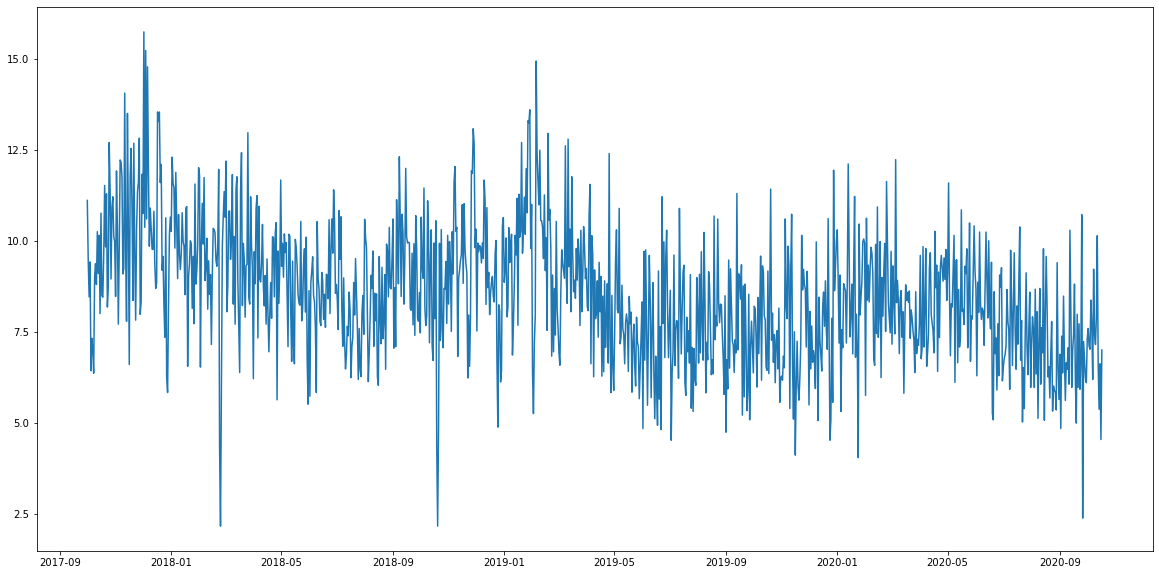

In [6]:
pl.figure(figsize=(20,10))
pl.plot(elec.loc[:, "Datetime"], elec.loc[:, "Yksiaikainen (kWh)"])
pl.locator_params(axis='y', nbins=6)
pl.show()

### Time series analysis

Complete guide to time series analysis, Towards Data Science: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

- Autocorrelation
- Seasonality
- Stationarity

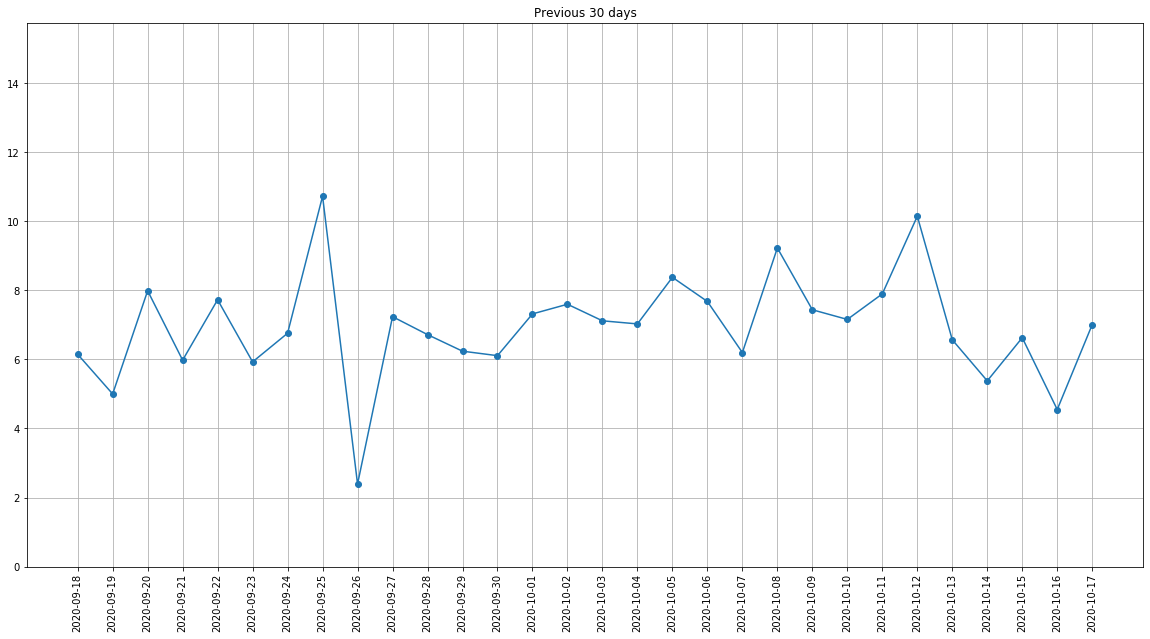

In [29]:
monthago = pd.to_datetime(pd.to_datetime(max(elec.Datetime)) - pd.Timedelta('30 days'))

pl.figure(figsize=(20,10))
pl.title("Previous 30 days")
pl.grid(axis="both")
pl.plot(elec.loc[elec.Datetime > monthago, "Datetime"], elec.loc[elec.Datetime > monthago, "Yksiaikainen (kWh)"],
       marker="o")
pl.xticks(elec.loc[elec.Datetime > monthago, "Datetime"], rotation="vertical")
pl.ylim(0, max(elec["Yksiaikainen (kWh)"]))
pl.show()

In [181]:
# Create temperature classes
# pd.cut(elec["Lämpötila"], bins=[-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]).factorize()

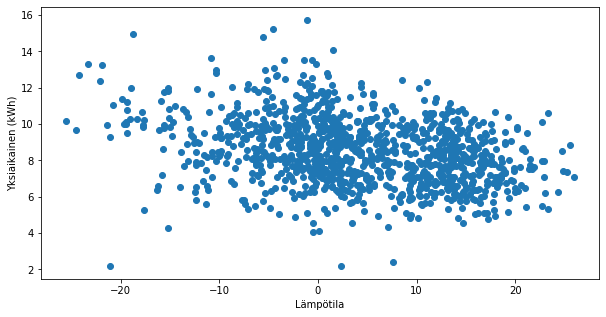

In [8]:
pl.figure(figsize=(10,5))
pl.scatter(elec["Lämpötila"], elec["Yksiaikainen (kWh)"])
pl.xlabel("Lämpötila")
pl.ylabel("Yksiaikainen (kWh)")
pl.show()

### Linear regression

In [9]:
slope, intercept, r_value, p_value, std_err = sts.linregress(elec["Lämpötila"], elec["Yksiaikainen (kWh)"])

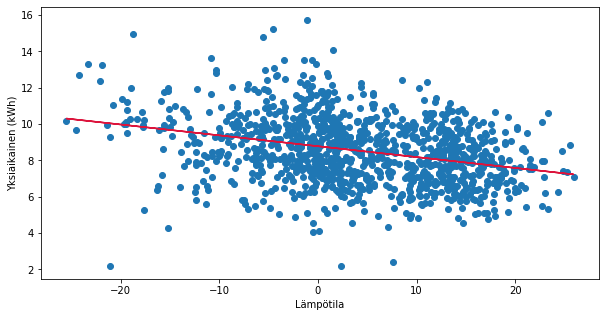

In [19]:
pl.figure(figsize=(10,5))
pl.scatter(elec["Lämpötila"], elec["Yksiaikainen (kWh)"])
pl.plot(elec["Lämpötila"], (slope * elec["Lämpötila"] + intercept), color="crimson")
pl.xlabel("Lämpötila")
pl.ylabel("Yksiaikainen (kWh)")
pl.show()

In [26]:
print("intercept: ", intercept)
print("slope: ", slope)
print("sd: ", std_err)
print("p-value: ", p_value)
print("r squared: ", r_value ** 2)

intercept:  8.77717947686314
slope:  -0.05980916497713802
sd:  0.005432087923260309
p-value:  7.84061531242028e-27
r squared:  0.09838093057670025


- Korrelaatiokerroin r on (keskiarvoonsa) keskistettyjen vektorien $x'$ ja $y'$ kulman kosini
- Kollineaarisuus